In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch as T
import torch.nn as nn
import torch.optim as O
from torch.utils.data import TensorDataset , DataLoader

from sklearn.preprocessing import MinMaxScaler , LabelEncoder
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from scipy import stats

import os
import tqdm


In [110]:
df = pd.read_csv("../../csvs/Housing_Prices/miami-housing.csv")

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13932 entries, 0 to 13931
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LATITUDE           13932 non-null  float64
 1   LONGITUDE          13932 non-null  float64
 2   PARCELNO           13932 non-null  int64  
 3   SALE_PRC           13932 non-null  float64
 4   LND_SQFOOT         13932 non-null  int64  
 5   TOT_LVG_AREA       13932 non-null  int64  
 6   SPEC_FEAT_VAL      13932 non-null  int64  
 7   RAIL_DIST          13932 non-null  float64
 8   OCEAN_DIST         13932 non-null  float64
 9   WATER_DIST         13932 non-null  float64
 10  CNTR_DIST          13932 non-null  float64
 11  SUBCNTR_DI         13932 non-null  float64
 12  HWY_DIST           13932 non-null  float64
 13  age                13932 non-null  int64  
 14  avno60plus         13932 non-null  int64  
 15  month_sold         13932 non-null  int64  
 16  structure_quality  139

In [112]:
df.describe()

,LATITUDE,LONGITUDE,PARCELNO,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality
count,13932.000000,13932.000000,1.393200e+04,1.393200e+04,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000
mean,25.728811,-80.327475,2.356496e+12,3.999419e+05,8620.879917,2058.044574,9562.493468,8348.548715,31690.993798,11960.285235,68490.327132,41115.047265,7723.770693,30.669251,0.014930,6.655828,3.513997
std,0.140633,0.089199,1.199290e+12,3.172147e+05,6070.088742,813.538535,13890.967782,6178.027333,17595.079468,11932.992369,32008.474808,22161.825935,6068.936108,21.153068,0.121276,3.301523,1.097444
min,25.434333,-80.542172,1.020008e+11,7.200000e+04,1248.000000,854.000000,0.000000,10.500000,236.100000,0.000000,3825.600000,1462.800000,90.200000,0.000000,0.000000,1.000000,1.000000
25%,25.620056,-80.403278,1.079160e+12,2.350000e+05,5400.000000,1470.000000,810.000000,3299.450000,18079.350000,2675.850000,42823.100000,23996.250000,2998.125000,14.000000,0.000000,4.000000,2.000000
50%,25.731810,-80.338911,3.040300e+12,3.100000e+05,7500.000000,1877.500000,2765.500000,7106.300000,28541.750000,6922.600000,65852.400000,41109.900000,6159.750000,26.000000,0.000000,7.000000,4.000000
75%,25.852269,-80.258019,3.060170e+12,4.280000e+05,9126.250000,2471.000000,12352.250000,12102.600000,44310.650000,19200.000000,89358.325000,53949.375000,10854.200000,46.000000,0.000000,9.000000,4.000000
max,25.974382,-80.119746,3.660170e+12,2.650000e+06,57064.000000,6287.000000,175020.000000,29621.500000,75744.900000,50399.800000,159976.500000,110553.800000,48167.300000,96.000000,1.000000,12.000000,5.000000


In [113]:
df

,LATITUDE,LONGITUDE,PARCELNO,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality
0,25.891031,-80.160561,622280070620,440000.0,9375,1753,0,2815.9,12811.4,347.6,42815.3,37742.2,15954.9,67,0,8,4
1,25.891324,-80.153968,622280100460,349000.0,9375,1715,0,4359.1,10648.4,337.8,43504.9,37340.5,18125.0,63,0,9,4
2,25.891334,-80.153740,622280100470,800000.0,9375,2276,49206,4412.9,10574.1,297.1,43530.4,37328.7,18200.5,61,0,2,4
3,25.891765,-80.152657,622280100530,988000.0,12450,2058,10033,4585.0,10156.5,0.0,43797.5,37423.2,18514.4,63,0,9,4
4,25.891825,-80.154639,622280100200,755000.0,12800,1684,16681,4063.4,10836.8,326.6,43599.7,37550.8,17903.4,42,0,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13927,25.783130,-80.259795,131320040990,275000.0,6780,967,6580,3844.5,20568.0,3252.4,22175.9,12150.1,917.4,16,0,4,4
13928,25.783585,-80.260354,131320040910,340000.0,7500,1854,2544,3593.6,20791.9,3077.7,22375.1,12316.8,738.2,26,0,5,4
13929,25.783793,-80.256126,131320040420,287500.0,8460,1271,2064,4143.2,20307.9,3588.4,20966.9,12433.0,743.7,16,0,7,4
13930,25.784007,-80.257542,131320040330,315000.0,7500,1613,3136,3986.9,20542.6,3589.1,21475.6,12458.0,626.1,16,0,8,4


In [114]:
from numpy import NaN


df["Geolocation"] = df["LATITUDE"] + df["LONGITUDE"]
df.drop(["LONGITUDE" , "LATITUDE"], axis = 1 , inplace= True)

df["GeolocationPriceLowerFarOcean"] = (df["Geolocation"] < df["Geolocation"].quantile(0.3))

df["TotalSpace"] = df["TOT_LVG_AREA"] + df["LND_SQFOOT"]
df.drop(["LND_SQFOOT" , "TOT_LVG_AREA"], axis = 1 , inplace= True)

df["TotalSpace"] = np.log1p(df["TotalSpace"])
df["PriceLowerSpace"] = (df["TotalSpace"] < df["TotalSpace"].quantile(0.3))
df["PriceLowerSpace"] = df["PriceLowerSpace"].astype(np.float32)

df["WatterInfluence"] = df["OCEAN_DIST"] + df["WATER_DIST"]
df.drop(["WATER_DIST" , "OCEAN_DIST"], axis = 1 , inplace= True)
df["WatterInfluence"] = np.log10(df["WatterInfluence"])
df["WatterInfluence"] ,_ = stats.boxcox(df["WatterInfluence"] + 1)

df["WatterImportance"] = df["WatterInfluence"] + df["SALE_PRC"]
df["WatterImportance"] = np.log1p(df["WatterImportance"])

df["WatterSalesPrice"] = df["WatterImportance"] + df["SALE_PRC"]
df["WatterSalesPrice"] = np.log1p(df["WatterSalesPrice"])

df["ControllDstnc"] = df["SUBCNTR_DI"] + df["CNTR_DIST"]
df["ControllDstnc"] = np.log10(df["ControllDstnc"])
df.drop(["SUBCNTR_DI" , "CNTR_DIST"], axis = 1 , inplace= True)

df["SPEC_FEAT_VAL"] = np.log10(df["SPEC_FEAT_VAL"])
df["RAIL_DIST"] = np.log1p(df["RAIL_DIST"])

df["PARCELNO"] = np.log10(df["PARCELNO"])

for cols in df.columns:
    df[cols] = np.where((df[cols] == -np.inf) | (df[cols] == np.inf), NaN , df[cols])
    

i:\Sonstiges\Programmieren\python\3.10.0\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [115]:
df

,PARCELNO,SALE_PRC,SPEC_FEAT_VAL,RAIL_DIST,HWY_DIST,age,avno60plus,month_sold,structure_quality,Geolocation,GeolocationPriceLowerFarOcean,TotalSpace,PriceLowerSpace,WatterInfluence,WatterImportance,WatterSalesPrice,ControllDstnc
0,11.793986,440000.0,NaN,7.943392,15954.9,67.0,0.0,8.0,4.0,-54.269530,0.0,9.317310,0.0,15659.734427,13.029504,12.994562,4.906106
1,11.793986,349000.0,NaN,8.380250,18125.0,63.0,0.0,9.0,4.0,-54.262643,0.0,9.313889,0.0,14031.365348,12.802247,12.762867,4.907655
2,11.793986,800000.0,4.692018,8.392514,18200.5,61.0,0.0,2.0,4.0,-54.262405,0.0,9.363233,0.0,13941.087480,13.609644,13.592385,4.907729
3,11.793986,988000.0,4.001431,8.430763,18514.4,63.0,0.0,9.0,4.0,-54.260893,0.0,9.582524,0.0,13369.620200,13.816880,13.803453,4.909667
4,11.793986,755000.0,4.222222,8.310021,17903.4,42.0,0.0,7.0,4.0,-54.262815,0.0,9.580869,0.0,14169.601095,13.553068,13.534492,4.909291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13927,11.118331,275000.0,3.818226,8.254659,917.4,16.0,0.0,4.0,4.0,-54.476665,0.0,8.955190,1.0,22212.325149,12.602205,12.524576,4.535623
13928,11.118331,340000.0,3.405517,8.187188,738.2,26.0,0.0,5.0,4.0,-54.476769,0.0,9.143666,0.0,22238.682471,12.800061,12.736741,4.540228
13929,11.118331,287500.0,3.314710,8.329465,743.7,16.0,0.0,7.0,4.0,-54.472332,0.0,9.183175,0.0,22252.974633,12.643534,12.569026,4.523745
13930,11.118331,315000.0,3.496376,8.291020,626.1,16.0,0.0,8.0,4.0,-54.473535,0.0,9.117567,0.0,22378.632992,12.728964,12.660372,4.530630


IQR : -1.000082530282203
Corr : -0.2105271563156374


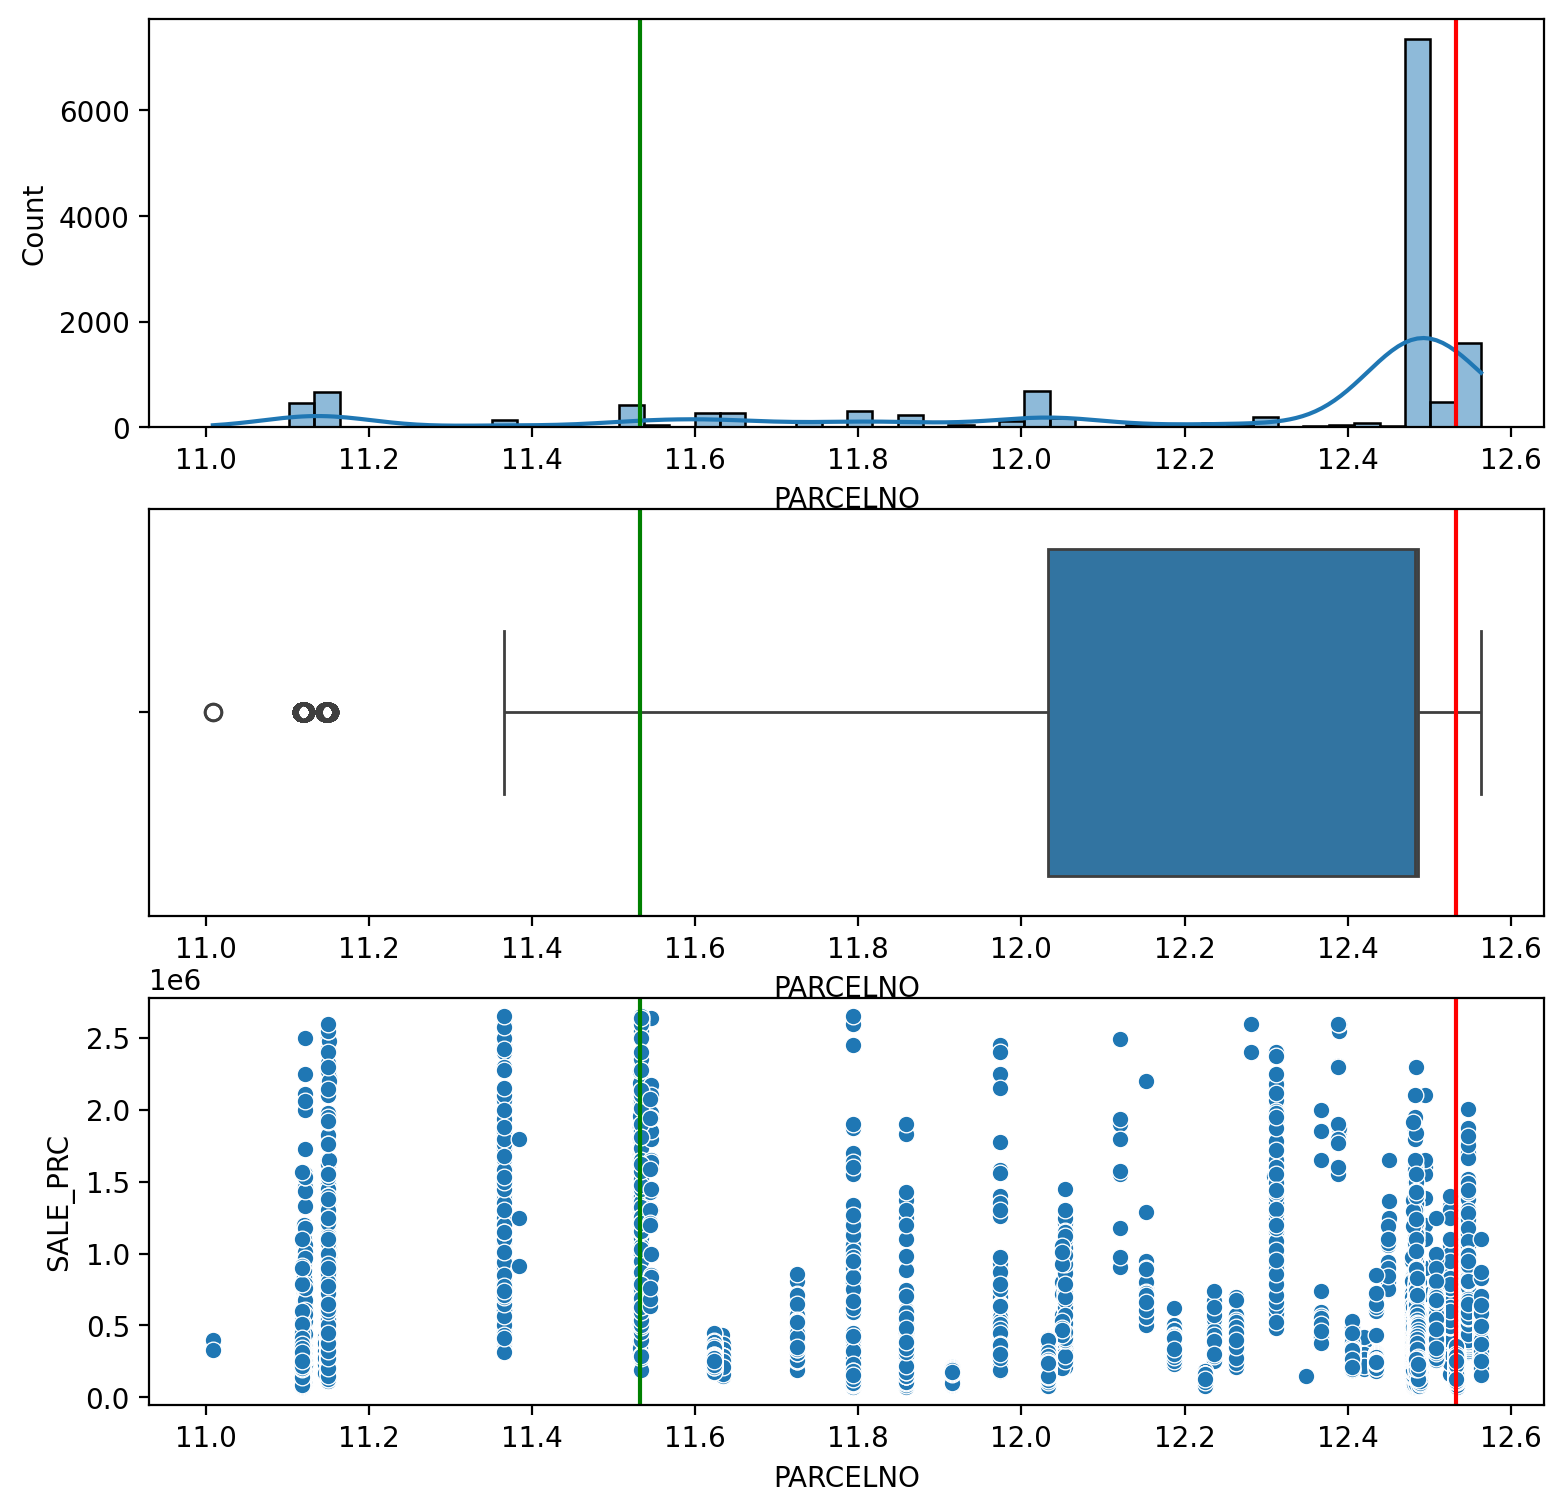

In [116]:
def Plots(lowerbound , higherbound , data , x , y):

    fig , axes = plt.subplots(3 , 1 , figsize = (9,9) , dpi = 200)

    Q1 = x.quantile(lowerbound)
    Q3 = x.quantile(higherbound)
    IQR = Q1 - Q3
    print(f"IQR : {IQR}")
    print(f"Corr : {x.corr(y)}")

    sns.histplot(x, bins = 50 , kde = True ,  ax= axes[0])
    axes[0].axvline(x.quantile(lowerbound) , color = "green")
    axes[0].axvline(x.quantile(higherbound) , color = "red")

    sns.boxplot(data = data , x = x  , ax= axes[1])
    axes[1].axvline(x.quantile(lowerbound) , color = "green")
    axes[1].axvline(x.quantile(higherbound) , color = "red")

    sns.scatterplot(data = data , x = x , y = y , ax= axes[2])
    axes[2].axvline(x.quantile(lowerbound) , color = "green")
    axes[2].axvline(x.quantile(higherbound) , color = "red")

    plt.show()

Plots(lowerbound = 0.1 , higherbound = 0.9 , data = df , x=df["PARCELNO"] , y=df["SALE_PRC"])

In [117]:
df.isnull().sum()

PARCELNO                            0
SALE_PRC                            0
SPEC_FEAT_VAL                    2290
RAIL_DIST                           0
HWY_DIST                            0
age                                 0
avno60plus                          0
month_sold                          0
structure_quality                   0
Geolocation                         0
GeolocationPriceLowerFarOcean       0
TotalSpace                          0
PriceLowerSpace                     0
WatterInfluence                     0
WatterImportance                    0
WatterSalesPrice                    0
ControllDstnc                       0
dtype: int64

In [118]:
imputer = SimpleImputer(strategy= "mean")
df["SPEC_FEAT_VAL"] = imputer.fit_transform(df[["SPEC_FEAT_VAL"]])

In [119]:
df.isnull().sum()

PARCELNO                         0
SALE_PRC                         0
SPEC_FEAT_VAL                    0
RAIL_DIST                        0
HWY_DIST                         0
age                              0
avno60plus                       0
month_sold                       0
structure_quality                0
Geolocation                      0
GeolocationPriceLowerFarOcean    0
TotalSpace                       0
PriceLowerSpace                  0
WatterInfluence                  0
WatterImportance                 0
WatterSalesPrice                 0
ControllDstnc                    0
dtype: int64

In [120]:
X = df.drop(["SALE_PRC"] , axis = 1).values
print(X.shape)
X = X.astype(np.float32)
X

(13932, 16)


array([[11.793986 ,  3.6684675,  7.9433923, ..., 13.029504 , 12.994562 ,
         4.906106 ],
       [11.793986 ,  3.6684675,  8.38025  , ..., 12.802247 , 12.762867 ,
         4.9076552],
       [11.793986 ,  4.692018 ,  8.392514 , ..., 13.609645 , 13.592385 ,
         4.9077287],
       ...,
       [11.118331 ,  3.3147097,  8.329465 , ..., 12.643534 , 12.569026 ,
         4.523745 ],
       [11.118331 ,  3.496376 ,  8.29102  , ..., 12.728964 , 12.660372 ,
         4.53063  ],
       [11.118331 ,  2.4248817,  8.241413 , ..., 12.515243 , 12.42927  ,
         4.5381665]], dtype=float32)

In [121]:
y = df["SALE_PRC"].values.reshape(-1,1)
print(y.shape)
y = y.astype(np.float32)
y

(13932, 1)


array([[440000.],
       [349000.],
       [800000.],
       ...,
       [287500.],
       [315000.],
       [250000.]], dtype=float32)

In [122]:
fold = KFold(n_splits= 10 , shuffle=True)
for train , test in fold.split(X ,y ):
    X_train , X_test = X[train] , X[test]
    y_train , y_test = y[train] , y[test]

In [123]:
print(f"Max of X_train : {X_train.max()}")
print(f"Max of X_test : {X_test.max()}")
print(f"Max of y_train : {y_train.max()}")
print(f"Max of y_test : {y_test.max()}")

print(f"\n min of X_train : {X_train.min()}")
print(f"min of X_test : {X_test.min()}")
print(f"min of y_train : {y_train.min()}")
print(f"min of y_test : {y_test.min()}")

Max of X_train : 52755.7109375
Max of X_test : 50661.49609375
Max of y_train : 2650000.0
Max of y_test : 2575000.0

 min of X_train : -55.06394577026367
min of X_test : -55.06575393676758
min of y_train : 72000.0
min of y_test : 77800.0


In [124]:
mmc = MinMaxScaler()
X_train = mmc.fit_transform(X_train)
X_test = mmc.transform(X_test)

ymmc = MinMaxScaler()
y_train = ymmc.fit_transform(y_train)
y_test = ymmc.transform(y_test)

In [125]:
print(f"Max of X_train : {X_train.max()}")
print(f"Max of X_test : {X_test.max()}")
print(f"Max of y_train : {y_train.max()}")
print(f"Max of y_test : {y_test.max()}")

print(f"\n min of X_train : {X_train.min()}")
print(f"min of X_test : {X_test.min()}")
print(f"min of y_train : {y_train.min()}")
print(f"min of y_test : {y_test.min()}")

Max of X_train : 1.0000004768371582
Max of X_test : 1.0000004768371582
Max of y_train : 0.9999999403953552
Max of y_test : 0.9709076285362244

 min of X_train : 0.0
min of X_test : -0.0019683837890625
min of y_train : 0.0
min of y_test : 0.0022498052567243576


In [126]:
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [127]:
X_train = T.from_numpy(X_train).float()
X_test = T.from_numpy(X_test).float()
y_train = T.from_numpy(y_train).float()
y_test = T.from_numpy(y_test).float()

In [128]:
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [129]:
print(X_train.shape)
print(X_train.shape[1])

print(y_train.shape)
print(y_train.shape[1])

torch.Size([12539, 16])
16
torch.Size([12539, 1])
1


In [130]:
X_train

tensor([[0.5051, 0.6535, 0.7004,  ..., 0.4818, 0.5020, 0.6602],
        [0.5051, 0.6535, 0.7560,  ..., 0.4151, 0.4377, 0.6612],
        [0.5051, 0.8787, 0.7576,  ..., 0.6520, 0.6678, 0.6613],
        ...,
        [0.0706, 0.5756, 0.7496,  ..., 0.3686, 0.3840, 0.4133],
        [0.0706, 0.6156, 0.7447,  ..., 0.3936, 0.4093, 0.4178],
        [0.0706, 0.3798, 0.7384,  ..., 0.3309, 0.3452, 0.4226]])

In [131]:
y_train

tensor([[0.1427],
        [0.1074],
        [0.2824],
        ...,
        [0.0836],
        [0.0943],
        [0.0690]])

In [132]:
class NN(nn.Module):

    def __init__(self, InDims = X_train.shape[1] , OutDims = y_train.shape[1]):
        super().__init__()
        self.ll1 = nn.Linear(InDims , 32)
        self.ll2 = nn.Linear(32 , 16)

        self.ll3 = nn.Linear(16 , 8)
        self.ll4 = nn.Linear(8 , OutDims)
        
        self.drop = nn.Dropout(p = (0.2))
        self.activation = nn.ReLU()
        
    def forward(self , X):

        X = self.activation(self.ll1(X))
        X = self.activation(self.ll2(X))
        X = self.drop(X)
        X = self.activation(self.ll3(X))
        X = self.ll4(X)

        return X

class Training():

    def __init__(self):
        self.lr = 1e-3
        self.device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
        self.model = NN().to(self.device)
        self.crit = O.Adam(self.model.parameters() , lr = self.lr)
        self.loss = nn.MSELoss()
        self.batchsize = 32
        self.epochs = 25

        self.TrainData = TensorDataset(X_train , y_train)
        self.TestData = TensorDataset(X_test , y_test)

        self.trainLoader = DataLoader(dataset= self.TrainData,
                                      shuffle=True,
                                      num_workers= os.cpu_count(),
                                      batch_size= self.batchsize)
        

        self.testLoader = DataLoader(dataset= self.TestData,
                                      num_workers= os.cpu_count(),
                                      batch_size= self.batchsize)

    def Train(self):

        LossPlot = []
        self.model.train()
        for i in range(self.epochs):
            currentLoss = 0.0
            with tqdm.tqdm(iterable=self.trainLoader , mininterval=0.1 , disable = False) as Pbar:
                Pbar.set_description(f"Epoch {i + 1}")
                for X , y in Pbar:
                    X , y = X.to(self.device) , y.to(self.device)

                    logits = self.model(X)
                    loss = self.loss(logits , y)
                    self.crit.zero_grad()
                    loss.backward()
                    self.crit.step()

                    currentLoss += loss.item()
                    Pbar.set_postfix({"Loss" :  loss.item()})

            avgLoss = currentLoss / len(self.trainLoader)
            LossPlot.append(avgLoss)
            print(f"Epoch : {i + 1}/{self.epochs} | Loss : {currentLoss / len(self.trainLoader):.4f}")
        return LossPlot

    def eval(self):
        TestLoss = []
        self.model.eval()
        with T.no_grad():
            currentLoss = 0.0
            with tqdm.tqdm(iterable=self.testLoader , mininterval=0.1 , disable = False) as Pbar:
                Pbar.set_description(f"Evaluating")
                for X , y in Pbar:
                    X , y = X.to(self.device) , y.to(self.device)

                    logits = self.model(X)
                    loss = self.loss(logits , y)

                currentLoss += loss.item()
                Pbar.set_postfix({"Loss" : loss.item()})
                
            avgLoss = currentLoss / len(self.testLoader)
            TestLoss.append(avgLoss)
            print(f"Evaluation | Loss : {currentLoss / len(self.testLoader):.4f}")
        return TestLoss

    def train_and_plot(self):
        train_losses = self.Train() 
        test_losses = []  

        for _ in range(self.epochs):
            test_losses.append(self.eval()[0]) 

        plt.figure(figsize=(9, 6), dpi=150)
        plt.plot(train_losses, marker='o', linestyle='-', color='b', label="Train Loss")
        plt.plot(test_losses, marker='s', linestyle='--', color='r', label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training & Test Loss über die Epochen")
        plt.legend()
        plt.grid(True)
        plt.show()

In [133]:
execute = Training()

In [134]:
execute.Train()

Epoch 1: 100%|██████████| 392/392 [00:06<00:00, 59.79it/s, Loss=0.00156]  


Epoch : 1/25 | Loss : 0.0054


Epoch 2: 100%|██████████| 392/392 [00:05<00:00, 70.38it/s, Loss=0.000894] 


Epoch : 2/25 | Loss : 0.0015


Epoch 3: 100%|██████████| 392/392 [00:05<00:00, 67.06it/s, Loss=0.000132] 


Epoch : 3/25 | Loss : 0.0010


Epoch 4: 100%|██████████| 392/392 [00:05<00:00, 69.34it/s, Loss=0.000167] 


Epoch : 4/25 | Loss : 0.0008


Epoch 5: 100%|██████████| 392/392 [00:05<00:00, 71.45it/s, Loss=0.000262] 


Epoch : 5/25 | Loss : 0.0008


Epoch 6: 100%|██████████| 392/392 [00:05<00:00, 72.18it/s, Loss=0.00148]  


Epoch : 6/25 | Loss : 0.0006


Epoch 7: 100%|██████████| 392/392 [00:05<00:00, 72.07it/s, Loss=0.000192] 


Epoch : 7/25 | Loss : 0.0005


Epoch 8: 100%|██████████| 392/392 [00:05<00:00, 67.46it/s, Loss=0.000344] 


Epoch : 8/25 | Loss : 0.0005


Epoch 9: 100%|██████████| 392/392 [00:05<00:00, 73.43it/s, Loss=0.000893] 


Epoch : 9/25 | Loss : 0.0004


Epoch 10: 100%|██████████| 392/392 [00:05<00:00, 73.13it/s, Loss=0.00015]  


Epoch : 10/25 | Loss : 0.0003


Epoch 11: 100%|██████████| 392/392 [00:05<00:00, 74.47it/s, Loss=0.000178] 


Epoch : 11/25 | Loss : 0.0003


Epoch 12: 100%|██████████| 392/392 [00:05<00:00, 70.25it/s, Loss=0.000152] 


Epoch : 12/25 | Loss : 0.0003


Epoch 13: 100%|██████████| 392/392 [00:05<00:00, 69.58it/s, Loss=0.000118] 


Epoch : 13/25 | Loss : 0.0002


Epoch 14: 100%|██████████| 392/392 [00:05<00:00, 71.75it/s, Loss=0.000729] 


Epoch : 14/25 | Loss : 0.0002


Epoch 15: 100%|██████████| 392/392 [00:05<00:00, 71.20it/s, Loss=0.000103] 


Epoch : 15/25 | Loss : 0.0002


Epoch 16: 100%|██████████| 392/392 [00:05<00:00, 73.35it/s, Loss=0.000112] 


Epoch : 16/25 | Loss : 0.0002


Epoch 17: 100%|██████████| 392/392 [00:05<00:00, 72.15it/s, Loss=3.83e-5]  


Epoch : 17/25 | Loss : 0.0002


Epoch 18: 100%|██████████| 392/392 [00:05<00:00, 69.90it/s, Loss=0.000299] 


Epoch : 18/25 | Loss : 0.0002


Epoch 19: 100%|██████████| 392/392 [00:05<00:00, 69.74it/s, Loss=7.77e-5]  


Epoch : 19/25 | Loss : 0.0002


Epoch 20: 100%|██████████| 392/392 [00:05<00:00, 72.90it/s, Loss=8.87e-5]  


Epoch : 20/25 | Loss : 0.0002


Epoch 21: 100%|██████████| 392/392 [00:05<00:00, 72.22it/s, Loss=3.48e-5]  


Epoch : 21/25 | Loss : 0.0001


Epoch 22: 100%|██████████| 392/392 [00:05<00:00, 69.67it/s, Loss=7.19e-5]  


Epoch : 22/25 | Loss : 0.0002


Epoch 23: 100%|██████████| 392/392 [00:06<00:00, 64.30it/s, Loss=6.52e-5]  


Epoch : 23/25 | Loss : 0.0002


Epoch 24: 100%|██████████| 392/392 [00:05<00:00, 68.69it/s, Loss=8.47e-5]  


Epoch : 24/25 | Loss : 0.0002


Epoch 25: 100%|██████████| 392/392 [00:05<00:00, 68.35it/s, Loss=0.000486] 

Epoch : 25/25 | Loss : 0.0002


[0.005433452030901003,
 0.0014864282977808273,
 0.0010408010870638204,
 0.0008195470127247972,
 0.0007511300994393627,
 0.0005993624797100689,
 0.00050037020559548,
 0.0004528305103678799,
 0.00042286348302788645,
 0.00031600929627511134,
 0.00034827630675325204,
 0.0002879384364117571,
 0.0002484813696671098,
 0.0001994590657580616,
 0.00023618548586028384,
 0.00022191293914500197,
 0.00019775781882632444,
 0.0002042304547604563,
 0.0001821675920595857,
 0.00017074805588649446,
 0.00014965929527738345,
 0.00018284912753605735,
 0.00016260594279814616,
 0.00015822756894318,
 0.00016026003823076373]

In [135]:
execute.eval()

Evaluating: 100%|██████████| 44/44 [00:04<00:00,  9.32it/s]

Evaluation | Loss : 0.0000


[1.2328850888562473e-05]

Epoch 1: 100%|██████████| 392/392 [00:05<00:00, 67.12it/s, Loss=2.91e-5]  


Epoch : 1/25 | Loss : 0.0002


Epoch 2: 100%|██████████| 392/392 [00:05<00:00, 71.12it/s, Loss=0.000103] 


Epoch : 2/25 | Loss : 0.0002


Epoch 3: 100%|██████████| 392/392 [00:05<00:00, 72.90it/s, Loss=0.000106] 


Epoch : 3/25 | Loss : 0.0002


Epoch 4: 100%|██████████| 392/392 [00:05<00:00, 74.87it/s, Loss=2.08e-5]  


Epoch : 4/25 | Loss : 0.0001


Epoch 5: 100%|██████████| 392/392 [00:05<00:00, 70.67it/s, Loss=3.73e-5]  


Epoch : 5/25 | Loss : 0.0002


Epoch 6: 100%|██████████| 392/392 [00:05<00:00, 69.66it/s, Loss=0.000114] 


Epoch : 6/25 | Loss : 0.0002


Epoch 7: 100%|██████████| 392/392 [00:05<00:00, 68.20it/s, Loss=0.000145] 


Epoch : 7/25 | Loss : 0.0002


Epoch 8: 100%|██████████| 392/392 [00:05<00:00, 72.98it/s, Loss=0.000244] 


Epoch : 8/25 | Loss : 0.0002


Epoch 9: 100%|██████████| 392/392 [00:05<00:00, 68.17it/s, Loss=7.8e-5]   


Epoch : 9/25 | Loss : 0.0001


Epoch 10: 100%|██████████| 392/392 [00:05<00:00, 71.80it/s, Loss=2.89e-5]  


Epoch : 10/25 | Loss : 0.0001


Epoch 11: 100%|██████████| 392/392 [00:05<00:00, 65.78it/s, Loss=3.77e-5]  


Epoch : 11/25 | Loss : 0.0002


Epoch 12: 100%|██████████| 392/392 [00:07<00:00, 55.83it/s, Loss=2.14e-5]  


Epoch : 12/25 | Loss : 0.0001


Epoch 13: 100%|██████████| 392/392 [00:06<00:00, 57.79it/s, Loss=0.000113] 


Epoch : 13/25 | Loss : 0.0001


Epoch 14: 100%|██████████| 392/392 [00:06<00:00, 57.01it/s, Loss=0.000152] 


Epoch : 14/25 | Loss : 0.0002


Epoch 15: 100%|██████████| 392/392 [00:07<00:00, 53.78it/s, Loss=0.000145] 


Epoch : 15/25 | Loss : 0.0002


Epoch 16: 100%|██████████| 392/392 [00:06<00:00, 60.69it/s, Loss=1.26e-5]  


Epoch : 16/25 | Loss : 0.0002


Epoch 17: 100%|██████████| 392/392 [00:07<00:00, 55.95it/s, Loss=3.43e-5]  


Epoch : 17/25 | Loss : 0.0001


Epoch 18: 100%|██████████| 392/392 [00:07<00:00, 52.75it/s, Loss=5.3e-5]   


Epoch : 18/25 | Loss : 0.0001


Epoch 19: 100%|██████████| 392/392 [00:07<00:00, 55.39it/s, Loss=2.9e-5]   


Epoch : 19/25 | Loss : 0.0001


Epoch 20: 100%|██████████| 392/392 [00:06<00:00, 61.68it/s, Loss=2.91e-5]  


Epoch : 20/25 | Loss : 0.0001


Epoch 21: 100%|██████████| 392/392 [00:06<00:00, 63.20it/s, Loss=5.45e-5]  


Epoch : 21/25 | Loss : 0.0002


Epoch 22: 100%|██████████| 392/392 [00:06<00:00, 61.34it/s, Loss=7.29e-5]  


Epoch : 22/25 | Loss : 0.0001


Epoch 23: 100%|██████████| 392/392 [00:06<00:00, 62.33it/s, Loss=3.21e-5]  


Epoch : 23/25 | Loss : 0.0001


Epoch 24: 100%|██████████| 392/392 [00:05<00:00, 66.70it/s, Loss=1.17e-5]  


Epoch : 24/25 | Loss : 0.0001


Epoch 25: 100%|██████████| 392/392 [00:05<00:00, 66.54it/s, Loss=0.000221] 


Epoch : 25/25 | Loss : 0.0001


Evaluating: 100%|██████████| 44/44 [00:04<00:00,  9.78it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:04<00:00, 10.12it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:04<00:00, 10.02it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:04<00:00,  9.37it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:04<00:00,  9.51it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:04<00:00,  9.82it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:04<00:00,  9.52it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:04<00:00,  9.06it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:04<00:00,  9.95it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:05<00:00,  8.55it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:04<00:00,  9.49it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:04<00:00,  8.83it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:05<00:00,  8.64it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:04<00:00,  9.26it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:04<00:00,  9.70it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:05<00:00,  8.30it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:05<00:00,  8.45it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:04<00:00,  9.85it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:05<00:00,  8.74it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:04<00:00,  9.81it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:05<00:00,  8.72it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:04<00:00,  9.73it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:04<00:00,  9.63it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:06<00:00,  7.14it/s]


Evaluation | Loss : 0.0000


Evaluating: 100%|██████████| 44/44 [00:05<00:00,  7.44it/s]

Evaluation | Loss : 0.0000


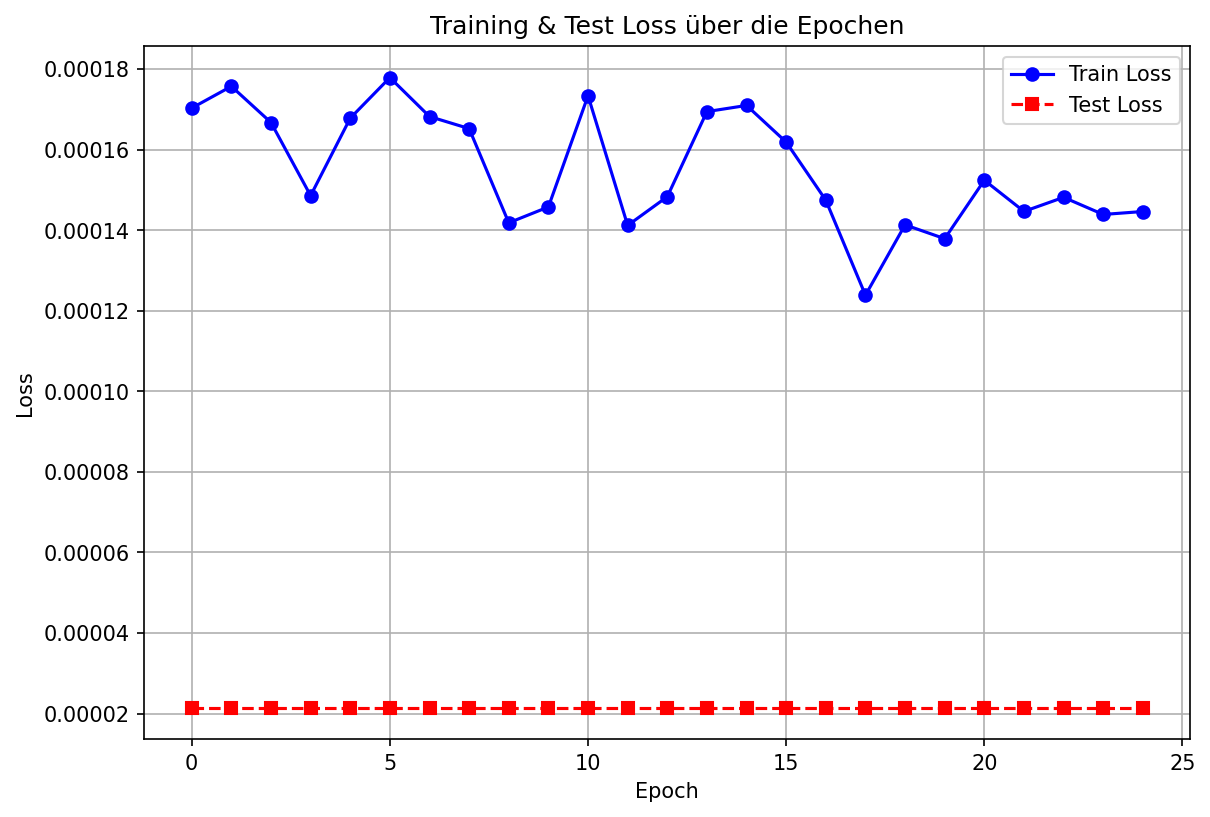

In [136]:
execute.train_and_plot()